## Loading Dependencies

In [2]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from langchain_google_vertexai import VertexAIEmbeddings
import vertexai
import langchain
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import tiktoken
import voyageai
from tqdm import tqdm
import pyarrow.parquet as pq
import spacy
from torch.utils.data import DataLoader, Dataset
from vertexai.language_models import TextEmbeddingModel


try:
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\mkolla1\LawChatBot\gcpservicekey.json"
except:
    print("Error at Try block")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"gcpservicekey.json"
    
PROJECT_ID = "lawrag"
LOCATION = "us-central1"
vertexai.init(project=PROJECT_ID, location=LOCATION)


voyageai.api_key = os.getenv("VOYAGE_API")

# Load NLP pipeline for query analysis
nlp = spacy.load("en_core_web_lg")

# Legal dictionary terms - expand as needed
LEGAL_TERMS = {
    "habeas corpus", "mens rea", "actus reus", "stare decisis", 
    "prima facie", "de novo", "res judicata", "certiorari",
    "statutory", "U.S.C.", "CFR", "jurisdiction", "adjudicate"
}

# Regex patterns for legal citations
CITATION_PATTERNS = [
    r'\d+\s+U\.S\.C\.\s+§*\s*\d+',  # US Code
    r'\d+\s+C\.F\.R\.\s+§*\s*\d+',   # Code of Federal Regulations
    r'[A-Za-z]+\s+v\.\s+[A-Za-z]+',  # Case names
]


## Embedding Generator for Gemini and Voyage

In [3]:
class EmbeddingGenerator:
    def __init__(self, gemini_model_name="text-embedding-005", voyage_model_name="voyage-law-2"):
        """
        Initializes the embedding generator with Gemini and VoyageAI models.
        """
        self.gemini_model = VertexAIEmbeddings(gemini_model_name)
        self.voyage_model_name = voyage_model_name
        self.voyage_client = voyageai.Client()
        self.voyage_tockenizer=AutoTokenizer.from_pretrained('voyageai/voyage-2')
        self.gemini_tockenizer=tiktoken.get_encoding("cl100k_base")

    def chunk_text_gemini(self, text, max_tokens=4096, overlap=512):
        tokens = self.gemini_tockenizer.encode(text)

        chunks = []
        start = 0
        while start < len(tokens):
            chunk = tokens[start:start + max_tokens]
            chunks.append(self.gemini_tockenizer.decode(chunk))
            start += max_tokens - overlap  # Sliding window
        return chunks
    
    def chunk_text_voyage(self, text, max_tokens=4096, overlap=512):
        """
        Splits text into chunks based on the token limit of voyage-law-2 tokenizer.
        Uses a sliding window approach with overlap.
        
        Args:
            text (str): The input text to be chunked.
            max_tokens (int): Maximum tokens per chunk (4096 for voyage-law-2).
            overlap (int): Overlapping tokens to maintain context between chunks.

        Returns:
            list of str: List of text chunks.
        """
        tokens = self.voyage_tockenizer.encode(text, add_special_tokens=False)

        chunks = []
        start = 0
        while start < len(tokens):
            chunk = tokens[start:start + max_tokens]
            chunks.append(self.voyage_tockenizer.decode(chunk))
            start += max_tokens - overlap

        return chunks
    
    def get_embeddings_gemini(self, texts, batch_size=32):
        """
        Compute embeddings using VertexAIEmbeddings in batches.

        Args:
            texts (list of str): List of text data to embed.
            batch_size (int): Number of texts to process per batch.

        Returns:
            list: List of embedding vectors.
        """
        embeddings = []
        texts= self.chunk_text_gemini(texts[0])
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
            batch = texts[i:i + batch_size]  # Get batch of texts
            batch_embeddings = self.gemini_model.embed_documents(batch)  # Generate embeddings
            embeddings.extend(batch_embeddings)  # Store results

        return embeddings

    def get_embeddings_voyage(self, texts, batch_size=32):
        """
        Compute embeddings using the VoyageAI Python client in batches.

        Args:
            texts (list of str): List of text data to embed.
            batch_size (int): Number of texts per batch.

        Returns:
            list: List of embedding vectors.
        """
        embeddings = []
        texts= self.chunk_text_voyage(texts[0])
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size] 
            
            try:
                response = self.voyage_client.embed(batch, model=self.voyage_model_name)
                batch_embeddings = response.embeddings  
                embeddings.extend(batch_embeddings)
            except Exception as e:
                print(f"Error processing batch {i // batch_size + 1}: {e}")

        return embeddings


## Saved Embeddings Loader

In [4]:
class LegalEmbeddingLoader:
    """Loads embeddings from parquet files for both models and all granularity levels."""
    
    def __init__(self, base_path):
        self.base_path = base_path
        self.gemini_embeddings = {}
        self.voyager_embeddings = {}
        self.metadata = {}
        
    def load_embeddings(self):
        """Load the six specified embedding files."""
        file_mappings = {
            "gemini_chapters": "embeddings_gemini_text-005_chapters_semchunk.parquet",
            "voyager_chapters": "embeddings_voyage_per_chapter_semchunked.parquet",
            "gemini_pages": "embeddings_gemini_text-005_pages_semchunk.parquet",
            "voyager_pages": "embeddings_voyage_per_pages_semchunked.parquet",
            "gemini_sections": "embeddings_gemini_text-005.parquet",
            "voyager_sections": "embeddings_voyage.parquet",
        }

        for key, file_name in file_mappings.items():
            print(self.base_path)
            file_path = os.path.join(self.base_path, key.split("_")[-1], file_name)
            print(file_path)
            if not os.path.exists(file_path):
                print(f"File {file_name} not found. Skipping...")
                continue

            # Read parquet file
            table = pq.read_table(file_path)
            df = table.to_pandas()
            print(f"\nColumns in {file_name}: {df.columns.tolist()}")
            # Extract embeddings and metadata
            embeddings = np.stack(df["Embedding"].values)

            # Determine model and granularity
            model, granularity = key.split("_")

            # Store embeddings
            if model == "gemini":
                self.gemini_embeddings[granularity] = torch.tensor(embeddings, dtype=torch.float32)
            else:
                self.voyager_embeddings[granularity] = torch.tensor(embeddings, dtype=torch.float32)

            # Store metadata
            self.metadata[key] = df.drop('Embedding', axis=1)

            print(f"Loaded {file_name} ({model} - {granularity})")
        return self.gemini_embeddings, self.voyager_embeddings, self.metadata

    def get_embedding_dimensions(self):
        """Return the dimensions of embeddings for both models."""
        gemini_dim = {k: v.shape[1] for k, v in self.gemini_embeddings.items()}
        voyager_dim = {k: v.shape[1] for k, v in self.voyager_embeddings.items()}
        return gemini_dim, voyager_dim

## Query Analyser and Intent Recognization

In [5]:
class LegalQueryAnalyzer:
    """Analyzes legal queries to determine intent and model weights."""
    
    def __init__(self, legal_terms=LEGAL_TERMS, citation_patterns=CITATION_PATTERNS):
        self.legal_terms = legal_terms
        self.citation_patterns = citation_patterns
        self.embedder = EmbeddingGenerator()
        
    def analyze_query(self, query):
        """
        Analyze query characteristics to determine model weights.
        Returns a dictionary of features and recommended weights.
        """
        # Process with spaCy
        print(f"QUERY IS: {query}")
        doc = nlp(query)
        print(type(doc))
        print(f"DOC AFTER PROCESSING IS QUERY IS: {doc}")
        # Feature extraction
        features = {
            'legal_term_density': self._calculate_legal_term_density(query),
            'citation_count': self._count_citations(query),
            'structural_complexity': self._assess_complexity(doc),
            'query_length': len(doc),
            'jurisdiction_signals': self._detect_jurisdiction(doc)
        }
        
        # Calculate recommended weights
        weights = self._determine_weights(features)
        
        return {
            'features': features,
            'weights': weights,
            'gemini_embedding': self.embedder.get_embeddings_gemini([query]),
            'voyage_embedding': self.embedder.get_embeddings_voyage([query])
        }
    
    def _calculate_legal_term_density(self, query):
        """Calculate the density of legal terminology in the query."""
        # Normalize and tokenize query
        query_lower = query.lower()
        total_tokens = len(query_lower.split())
        
        # Count legal terms
        legal_term_count = sum(1 for term in self.legal_terms if term.lower() in query_lower)
        
        # Calculate density
        if total_tokens > 0:
            return (legal_term_count / total_tokens) * 100
        return 0
    
    def _count_citations(self, query):
        """Count legal citations in the query."""
        citation_count = 0
        for pattern in self.citation_patterns:
            citation_count += len(re.findall(pattern, query))
        return citation_count
    
    def _assess_complexity(self, doc):
        """
        Assess the structural complexity of the query.
        Returns a score from 0-1 based on:
        - Number of clauses
        - Presence of legal conditionals
        - Sentence structure complexity
        """
        # Count clauses
        clause_markers = ["if", "when", "whether", "notwithstanding", "provided that"]
        clause_count = sum(1 for token in doc if token.text.lower() in clause_markers)
        
        # Check for complex legal conditionals
        has_conditionals = any(cm in doc.text.lower() for cm in clause_markers)
        
        # Assess syntactic complexity (simplified)
        depth = max((token.dep_.count('_') for token in doc), default=0)
        
        # Calculate complexity score (0-1)
        complexity = min(1.0, (clause_count * 0.2) + (0.3 if has_conditionals else 0) + (depth * 0.1))
        
        return complexity
    
    def _detect_jurisdiction(self, doc):
        """
        Detect jurisdictional signals in the query.
        Returns a dictionary of jurisdictional features.
        """
        # Look for jurisdictional entities
        jurisdictions = {
            'federal': 0,
            'state': 0,
            'international': 0,
            'specific_court': None
        }
        
        # Check for federal signals
        federal_terms = ["federal", "U.S.", "United States", "SCOTUS", "Supreme Court"]
        jurisdictions['federal'] = any(term.lower() in doc.text.lower() for term in federal_terms)
        
        # Check for state signals
        state_names = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", 
    "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", 
    "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", 
    "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", 
    "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
    "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", 
    "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]
  # Add all states
        jurisdictions['state'] = any(state in doc.text for state in state_names)
        
        # Check for international signals
        international_terms = ["international", "foreign", "treaty", "convention"]
        jurisdictions['international'] = any(term.lower() in doc.text.lower() for term in international_terms)
        
        # Look for specific courts
        court_patterns = ["Circuit", "District Court", "Supreme Court"]
        for pattern in court_patterns:
            if pattern in doc.text:
                jurisdictions['specific_court'] = pattern
                break
                
        return jurisdictions
    
    def _determine_weights(self, features):
        """
        Determine the optimal weights for each model based on features.
        Uses a rule-based approach initially, could be replaced with ML model.
        """
        # Default weights slightly favor specialized model
        gemini_weight = 0.4
        voyager_weight = 0.6
        
        # Adjust for legal density and citations
        if features['legal_term_density'] > 5 or features['citation_count'] > 0:
            # Increase weight for legal model
            voyager_weight += 0.15
            gemini_weight -= 0.15
        
        # Adjust for complexity
        if features['structural_complexity'] > 0.7:
            voyager_weight += 0.1
            gemini_weight -= 0.1
        
        # Adjust for jurisdictional specificity
        if features['jurisdiction_signals']['specific_court']:
            voyager_weight += 0.1
            gemini_weight -= 0.1
        
        # Ensure weights are valid
        voyager_weight = min(max(voyager_weight, 0.1), 0.9)
        gemini_weight = 1.0 - voyager_weight
        
        return {
            'gemini': gemini_weight,
            'voyager': voyager_weight
        }


## Fusion Retrival

In [ ]:
#         gemini_section_norm = gemini_section_proj
#         gemini_chapter_norm = gemini_chapter_proj
#         gemini_page_norm = gemini_page_proj

#         voyager_section_norm = voyager_section_proj
#         voyager_chapter_norm = voyager_chapter_proj
#         voyager_page_norm = voyager_page_proj

# gemini_query_norm = gemini_query_projected
#         voyager_query_norm = voyager_query_projected


        # Cosine similarity calculation using PyTorch
        # gemini_section_similarities = F.cosine_similarity(gemini_section_proj, gemini_query_projected, dim=1)
        # gemini_chapter_similarities = F.cosine_similarity(gemini_chapter_proj, gemini_query_projected, dim=1)
        # gemini_page_similarities = F.cosine_similarity(gemini_page_proj, gemini_query_projected, dim=1)

        # voyager_section_similarities = F.cosine_similarity(voyager_section_proj, voyager_query_projected, dim=1)
        # voyager_chapter_similarities = F.cosine_similarity(voyager_chapter_proj, voyager_query_projected, dim=1)
        # voyager_page_similarities = F.cosine_similarity(voyager_page_proj, voyager_query_projected, dim=1)

In [15]:
class FusionRetrival(nn.Module):
    def __init__(self, output_dim=1024, top_n=10):
        super(FusionRetrival, self).__init__()
        
        self.output_dim = output_dim
        self.top_n = top_n
        self.granularities = ['sections', 'chapters', 'pages']

        # Query projectors
        self.gemini_query_projector = nn.Linear(768, 768)
        self.voyager_query_projector = nn.Linear(1024, output_dim)
        
        # Document projectors
        self.gemini_projector = nn.Linear(768, 768)
        self.voyager_projector = nn.Linear(1024, output_dim)

        # Aggregation
        self.layer_norm = nn.LayerNorm(output_dim)


    def forward(self, gemini_embeddings, voyager_embeddings, gemini_query_embedding, voyager_query_embedding):
        # Compute cosine similarities directly without projections and normalizations
        gemini_section_similarities = F.cosine_similarity(gemini_embeddings['sections'], gemini_query_embedding)
        gemini_chapter_similarities = F.cosine_similarity(gemini_embeddings['chapters'], gemini_query_embedding)
        gemini_page_similarities = F.cosine_similarity(gemini_embeddings['pages'], gemini_query_embedding)

        voyager_section_similarities = F.cosine_similarity(voyager_embeddings['sections'], voyager_query_embedding)
        voyager_chapter_similarities = F.cosine_similarity(voyager_embeddings['chapters'], voyager_query_embedding)
        voyager_page_similarities = F.cosine_similarity(voyager_embeddings['pages'], voyager_query_embedding)

        # Apply softmax to the similarity scores
        gemini_section_weights = F.softmax(gemini_section_similarities, dim=0)
        gemini_chapter_weights = F.softmax(gemini_chapter_similarities, dim=0)
        gemini_page_weights = F.softmax(gemini_page_similarities, dim=0)

        voyager_section_weights = F.softmax(voyager_section_similarities, dim=0)
        voyager_chapter_weights = F.softmax(voyager_chapter_similarities, dim=0)
        voyager_page_weights = F.softmax(voyager_page_similarities, dim=0)

        print(f"Shape of gemini_section_weights: {gemini_section_weights.shape}")
        print(f"Shape of voyager_section_weights: {voyager_section_weights.shape}")
        print(f"Shape of gemini_chapter_weights: {gemini_chapter_weights.shape}")
        print(f"Shape of voyager_chapter_weights: {voyager_chapter_weights.shape}")
        print(f"Shape of gemini_page_weights: {gemini_page_weights.shape}")
        print(f"Shape of voyager_page_weights: {voyager_page_weights.shape}")
        # Get top N indices
        gemini_section_top_values, gemini_section_top_indices = torch.topk(gemini_section_weights, self.top_n)
        gemini_chapter_top_values, gemini_chapter_top_indices = torch.topk(gemini_chapter_weights, self.top_n)
        gemini_page_top_values, gemini_page_top_indices = torch.topk(gemini_page_weights, self.top_n)

        voyager_section_top_values, voyager_section_top_indices = torch.topk(voyager_section_weights, self.top_n)
        voyager_chapter_top_values, voyager_chapter_top_indices = torch.topk(voyager_chapter_weights, self.top_n)
        voyager_page_top_values, voyager_page_top_indices = torch.topk(voyager_page_weights, self.top_n)

        # Store results in dictionary
        top_indices_dict = {
            'sections': {
                "gemini_top_values": gemini_section_top_values,
                "gemini_top_indices": gemini_section_top_indices,
                "voyager_top_values": voyager_section_top_values,
                "voyager_top_indices": voyager_section_top_indices
            },
            'chapters': {
                "gemini_top_values": gemini_chapter_top_values,
                "gemini_top_indices": gemini_chapter_top_indices,
                "voyager_top_values": voyager_chapter_top_values,
                "voyager_top_indices": voyager_chapter_top_indices
            },
            'pages': {
                "gemini_top_values": gemini_page_top_values,
                "gemini_top_indices": gemini_page_top_indices,
                "voyager_top_values": voyager_page_top_values,
                "voyager_top_indices": voyager_page_top_indices
            }
        }

        return {
            'top_indices': top_indices_dict
        }

    def forward1(self, gemini_embeddings, voyager_embeddings, gemini_query_embedding, voyager_query_embedding):
        # Project query embeddings
        gemini_query_projected = self.gemini_query_projector(gemini_query_embedding)
        voyager_query_projected = self.voyager_query_projector(voyager_query_embedding)

        # Normalize query embeddings
        gemini_query_norm = F.normalize(gemini_query_projected, p=2, dim=1)
        voyager_query_norm = F.normalize(voyager_query_projected, p=2, dim=1)
        
        # Process embeddings per granularity
        gemini_section_proj = self.gemini_projector(gemini_embeddings['sections'])
        gemini_chapter_proj = self.gemini_projector(gemini_embeddings['chapters'])
        gemini_page_proj = self.gemini_projector(gemini_embeddings['pages'])

        voyager_section_proj = self.voyager_projector(voyager_embeddings['sections'])
        voyager_chapter_proj = self.voyager_projector(voyager_embeddings['chapters'])
        voyager_page_proj = self.voyager_projector(voyager_embeddings['pages'])

        gemini_section_proj = gemini_embeddings['sections']
        gemini_chapter_proj = gemini_embeddings['chapters']
        gemini_page_proj = gemini_embeddings['pages']

        voyager_section_proj = voyager_embeddings['sections']
        voyager_chapter_proj = voyager_embeddings['chapters']
        voyager_page_proj = voyager_embeddings['pages']

        # Normalize document embeddings
        gemini_section_norm = F.normalize(gemini_section_proj, p=2, dim=1)
        gemini_chapter_norm = F.normalize(gemini_chapter_proj, p=2, dim=1)
        gemini_page_norm = F.normalize(gemini_page_proj, p=2, dim=1)

        voyager_section_norm = F.normalize(voyager_section_proj, p=2, dim=1)
        voyager_chapter_norm = F.normalize(voyager_chapter_proj, p=2, dim=1)
        voyager_page_norm = F.normalize(voyager_page_proj, p=2, dim=1)
        

        # Compute cosine similarity using matrix multiplication
        gemini_section_similarities = torch.matmul(gemini_section_norm, gemini_query_norm.T).squeeze(1)
        gemini_chapter_similarities = torch.matmul(gemini_chapter_norm, gemini_query_norm.T).squeeze(1)
        gemini_page_similarities = torch.matmul(gemini_page_norm, gemini_query_norm.T).squeeze(1)

        voyager_section_similarities = torch.matmul(voyager_section_norm, voyager_query_norm.T).squeeze(1)
        voyager_chapter_similarities = torch.matmul(voyager_chapter_norm, voyager_query_norm.T).squeeze(1)
        voyager_page_similarities = torch.matmul(voyager_page_norm, voyager_query_norm.T).squeeze(1)


        # Apply softmax
        gemini_section_weights = F.softmax(gemini_section_similarities, dim=0)
        gemini_chapter_weights = F.softmax(gemini_chapter_similarities, dim=0)
        gemini_page_weights = F.softmax(gemini_page_similarities, dim=0)

        voyager_section_weights = F.softmax(voyager_section_similarities, dim=0)
        voyager_chapter_weights = F.softmax(voyager_chapter_similarities, dim=0)
        voyager_page_weights = F.softmax(voyager_page_similarities, dim=0)

        print(f"Shape of gemini_section_weights: {gemini_section_weights.shape}")
        print(f"Shape of voyager_section_weights: {voyager_section_weights.shape}")
        print(f"Shape of gemini_chapter_weights: {gemini_chapter_weights.shape}")
        print(f"Shape of voyager_chapter_weights: {voyager_chapter_weights.shape}")
        print(f"Shape of gemini_page_weights: {gemini_page_weights.shape}")
        print(f"Shape of voyager_page_weights: {voyager_page_weights.shape}")
        # Get top N indices
        gemini_section_top_values, gemini_section_top_indices = torch.topk(gemini_section_weights, self.top_n)
        gemini_chapter_top_values, gemini_chapter_top_indices = torch.topk(gemini_chapter_weights, self.top_n)
        gemini_page_top_values, gemini_page_top_indices = torch.topk(gemini_page_weights, self.top_n)

        voyager_section_top_values, voyager_section_top_indices = torch.topk(voyager_section_weights, self.top_n)
        voyager_chapter_top_values, voyager_chapter_top_indices = torch.topk(voyager_chapter_weights, self.top_n)
        voyager_page_top_values, voyager_page_top_indices = torch.topk(voyager_page_weights, self.top_n)

        # Store results in dictionary
        top_indices_dict = {
            'sections': {
                "gemini_top_values": gemini_section_top_values,
                "gemini_top_indices": gemini_section_top_indices,
                "voyager_top_values": voyager_section_top_values,
                "voyager_top_indices": voyager_section_top_indices
            },
            'chapters': {
                "gemini_top_values": gemini_chapter_top_values,
                "gemini_top_indices": gemini_chapter_top_indices,
                "voyager_top_values": voyager_chapter_top_values,
                "voyager_top_indices": voyager_chapter_top_indices
            },
            'pages': {
                "gemini_top_values": gemini_page_top_values,
                "gemini_top_indices": gemini_page_top_indices,
                "voyager_top_values": voyager_page_top_values,
                "voyager_top_indices": voyager_page_top_indices
            }
        }
        print("FINAL")
        return {
            'top_indices': top_indices_dict
        }


In [16]:
import math

def remove_duplicates(top_indices_dict):
    """
    Removes duplicate indices within each granularity (sections, chapters, pages)
    while keeping the one with the higher value. If values are equal, remove from Gemini.
    """
    for granularity in top_indices_dict:
        gemini_indices = [int(idx.item()) if hasattr(idx, 'item') else int(idx) for idx in top_indices_dict[granularity]["gemini_top_indices"]]
        gemini_values = [float(val.item()) if hasattr(val, 'item') else float(val) for val in top_indices_dict[granularity]["gemini_top_values"]]
        voyager_indices = [int(idx.item()) if hasattr(idx, 'item') else int(idx) for idx in top_indices_dict[granularity]["voyager_top_indices"]]
        voyager_values = [float(val.item()) if hasattr(val, 'item') else float(val) for val in top_indices_dict[granularity]["voyager_top_values"]]
        
        gemini_map = {idx: val for idx, val in zip(gemini_indices, gemini_values)}
        voyager_map = {idx: val for idx, val in zip(voyager_indices, voyager_values)}
        
        # Identify duplicates and remove based on the given rule
        common_indices = set(gemini_map.keys()).intersection(set(voyager_map.keys()))
        for idx in common_indices:
            if gemini_map[idx] > voyager_map[idx]:
                del voyager_map[idx]
            else:
                del gemini_map[idx]
        
        # Update lists after processing
        top_indices_dict[granularity]["gemini_top_indices"] = list(gemini_map.keys())
        top_indices_dict[granularity]["gemini_top_values"] = list(gemini_map.values())
        top_indices_dict[granularity]["voyager_top_indices"] = list(voyager_map.keys())
        top_indices_dict[granularity]["voyager_top_values"] = list(voyager_map.values())
    
    return top_indices_dict

def get_weighted_indices(top_indices_dict, gemini_weight, voyager_weight):
    """
    Selects a weighted number of indices based on provided weights.
    """
    for granularity in top_indices_dict:
        gemini_indices = top_indices_dict[granularity]["gemini_top_indices"]
        gemini_values = top_indices_dict[granularity]["gemini_top_values"]
        voyager_indices = top_indices_dict[granularity]["voyager_top_indices"]
        voyager_values = top_indices_dict[granularity]["voyager_top_values"]
        
        num_gemini = math.ceil(len(gemini_indices) * gemini_weight)
        num_voyager = math.ceil(len(voyager_indices) * voyager_weight)
        
        top_indices_dict[granularity]["gemini_top_indices"] = gemini_indices[:num_gemini]
        top_indices_dict[granularity]["gemini_top_values"] = gemini_values[:num_gemini]
        top_indices_dict[granularity]["voyager_top_indices"] = voyager_indices[:num_voyager]
        top_indices_dict[granularity]["voyager_top_values"] = voyager_values[:num_voyager]
    
    print("FINAL")
    return {
        'top_indices': top_indices_dict
    }


In [14]:
import torch
import os
from torch import nn
import torch.nn.functional as F
import pyarrow.parquet as pq
import numpy as np

def test_multi_level_attention(base_path, query, forward_fn):
    """
    Test function for MultiLevelAttention model using real embeddings from saved files.
    
    Args:
        base_path (str): Path to the directory containing embedding parquet files.
        query_embedding (torch.Tensor): Query embedding tensor with shape [768].
    
    Returns:
        None
    """
    global output
    # Load embeddings
    loader = LegalEmbeddingLoader(base_path)
    gemini_embeddings, voyager_embeddings, metadata = loader.load_embeddings()

    # Initialize the model
    model = FusionRetrival(output_dim=1024)

    # Analyze query
    query_analyzer = LegalQueryAnalyzer()
    query_output = query_analyzer.analyze_query(str(query))

    # Run the model
    if forward_fn == "simple":
        output = model.forward(
            gemini_embeddings, 
            voyager_embeddings, 
            torch.tensor(query_output['gemini_embedding']),
            torch.tensor(query_output['voyage_embedding'])
        )
    else:
        output = model.forward1(
            gemini_embeddings, 
            voyager_embeddings, 
            torch.tensor(query_output['gemini_embedding']),
            torch.tensor(query_output['voyage_embedding'])
        )
    
    for granularity, data in output['top_indices'].items():
        print(f"\n--- {granularity.capitalize()} ---")
        print(f"Gemini Top Indices: {data['gemini_top_indices']} GEMINI TOP VALUES: {data['gemini_top_values']}")
        print(f"Voyager Top Indices: {data['voyager_top_indices']} VOYAGER TOP VALUES: {data['voyager_top_values']}")
    # print("AFTER Processing and WEIGHTED")

    cleaned_top_indices = remove_duplicates(output['top_indices'])
    final_indices = get_weighted_indices(cleaned_top_indices, gemini_weight=0.8, voyager_weight=0.2)
    print(final_indices)
    for granularity, data in final_indices['top_indices'].items():
        print(f"\n--- {granularity.capitalize()} ---")
        print(f"Gemini Top Indices: {data['gemini_top_indices']} GEMINI TOP VALUES: {data['gemini_top_values']}")
        print(f"Voyager Top Indices: {data['voyager_top_indices']} VOYAGER TOP VALUES: {data['voyager_top_values']}")
base_path = "New_Embeddings_2025" 
query = """such vessel, out of port or from the United States, shall be fined under this title or imprisoned not
more than ten years, or both.
In addition, such vessel, her tackle, apparel, furniture, equipment, and her cargo shall be forfeited
to the United States.
The Secretary of the Treasury is authorized to promulgate regulations upon compliance with
which vessels engaged in the coastwise trade or fisheries or used solely for pleasure may be relieved
"""
test_multi_level_attention(base_path, query, forward_fn="simple")


New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_pages_semchunk.parquet (gemini - pages)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_voyage_per_pages_semchunked.parquet

Columns in embeddings_voyage_per_pages_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_pages_se

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])

--- Sections ---
Gemini Top Indices: tensor([ 108, 1037,  720, 1033, 1035]) GEMINI TOP VALUES: tensor([0.0008, 0.0007, 0.0007, 0.0007, 0.0007])
Voyager Top Indices: tensor([1036, 1037,  108,  720, 1034]) VOYAGER TOP VALUES: tensor([0.0009, 0.0009, 0.0008, 0.0008, 0.0008])

--- Chapters ---
Gemini Top Indices: tensor([ 54, 565, 370,  59, 566]) GEMINI TOP VALUES: tensor([0.0015, 0.0015, 0.0015, 0.0015, 0.0015])
Voyager Top Indices: tensor([566,  54, 595, 565,  55]) VOYAGER TOP VALUES: tensor([0.0017, 0.0016, 0.0016, 0.0015, 0.0015])

--- Pages ---
Gemini Top Indices: tensor([ 637,  640, 1296,  639, 1287]) GEMINI TOP VALUES: tensor([0.0006, 0.0006, 0.0006, 0.0005, 0.0005])
Voyager Top I

## Retrive Content by Index and Testing the Methods

In [8]:


import pandas as pd

# Load the embeddings files
gemini_sections_df = pd.read_parquet(r"New_Embeddings_2025\sections\embeddings_gemini_text-005.parquet")
gemini_pages_df = pd.read_parquet(r"New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet")
gemini_chapters_df = pd.read_parquet(r"New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet")

voyage_sections_df = pd.read_parquet(r"New_Embeddings_2025\sections\embeddings_voyage.parquet")
voyage_pages_df = pd.read_parquet(r"New_Embeddings_2025\pages\embeddings_voyage_per_pages_semchunked.parquet")
voyage_chapters_df = pd.read_parquet(r"New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet")

def get_processed_content_by_index(index, source, model):
    """
    Retrieve the Processed_Content or chunk based on the specified index and source.

    Args:
        index (int): The row index to retrieve.
        source (str): The source dataset ("gemini_text", "gemini_pages", or "voyage").

    Returns:
        str: The corresponding Processed_Content or chunk.
    """
    if model== "gemini":
        if source == "sections":
            return gemini_sections_df.loc[index, "Processed_Content"] if index in gemini_sections_df.index else None
        elif source == "pages":
            return gemini_pages_df.loc[index, "chunk"] if index in gemini_pages_df.index else None
        elif source == "chapters":
            return gemini_chapters_df.loc[index, "chunk"] if index in gemini_chapters_df.index else None
        else:
            return "Invalid source specified."
    if model == "voyage":
        if source == "sections":
            return voyage_sections_df.loc[index, "Processed_Content"] if index in voyage_sections_df.index else None
        elif source == "pages":
            return voyage_pages_df.loc[index, "chunk"] if index in voyage_pages_df.index else None
        elif source == "chapters":
            return voyage_chapters_df.loc[index, "chunk"] if index in voyage_chapters_df.index else None
        else:
            return "Invalid source specified."

# Example Usage:
# index_to_fetch = 637  # Change this index based on your needs
# print(get_processed_content_by_index(index_to_fetch, source="sections", model= "gemini"))  # For Gemini Text
# print("-----------------------------------------------")
# print(get_processed_content_by_index(index_to_fetch, source="pages", model= "gemini"))  # For Gemini Pages
# print("-----------------------------------------------")
# print(get_processed_content_by_index(index_to_fetch, source="chapters", model= "gemini"))  # For Voyage


## Comparing the Simple Similarily Search and Advanced One Across Granualarities

New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_pages_semchunk.parquet (gemini - pages)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_voyage_per_pages_semchunked.parquet

Columns in embeddings_voyage_per_pages_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_pages_se

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parque

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parque

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parque

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parque

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
Generating RAG comparison visualization...
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embed

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parque

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parque

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parque

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parque

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_gemini_text-005_chapters_semchunk.parquet

Columns in embeddings_gemini_text-005_chapters_semchunk.parquet: ['chunk', 'Embedding']
Loaded embeddings_gemini_text-005_chapters_semchunk.parquet (gemini - chapters)
New_Embeddings_2025
New_Embeddings_2025\chapters\embeddings_voyage_per_chapter_semchunked.parquet

Columns in embeddings_voyage_per_chapter_semchunked.parquet: ['chunk', 'Embedding']
Loaded embeddings_voyage_per_chapter_semchunked.parquet (voyager - chapters)
New_Embeddings_2025
New_Embeddings_2025\pages\embeddings_gemini_text-005_pages_semchunk.parquet

Columns in embeddings_gemini_text-005_pages_semchunk.parquet: ['c

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Shape of gemini_section_weights: torch.Size([1647])
Shape of voyager_section_weights: torch.Size([1647])
Shape of gemini_chapter_weights: torch.Size([809])
Shape of voyager_chapter_weights: torch.Size([809])
Shape of gemini_page_weights: torch.Size([2176])
Shape of voyager_page_weights: torch.Size([2176])
FINAL
Visualization complete. Here's how to interpret the plots:
- Each plot shows a different granularity: sections, pages, and chapters
- Points are colored by model (Gemini: blue, Voyager: red)
- Darker colors represent the Simple approach
- Lighter colors represent the Advanced approach
- Different markers (○, □, △, ◇, ⬟) represent different queries
- The x-axis shows the index retrieved
- The y-axis shows the similarity score

This visualization allows you to compare:
1. How the same model performs with different approaches (Simple vs Advanced)
2. How different models perform with the same approach
3. Which indices tend to be retrieved across multiple queries
4. The distribution 

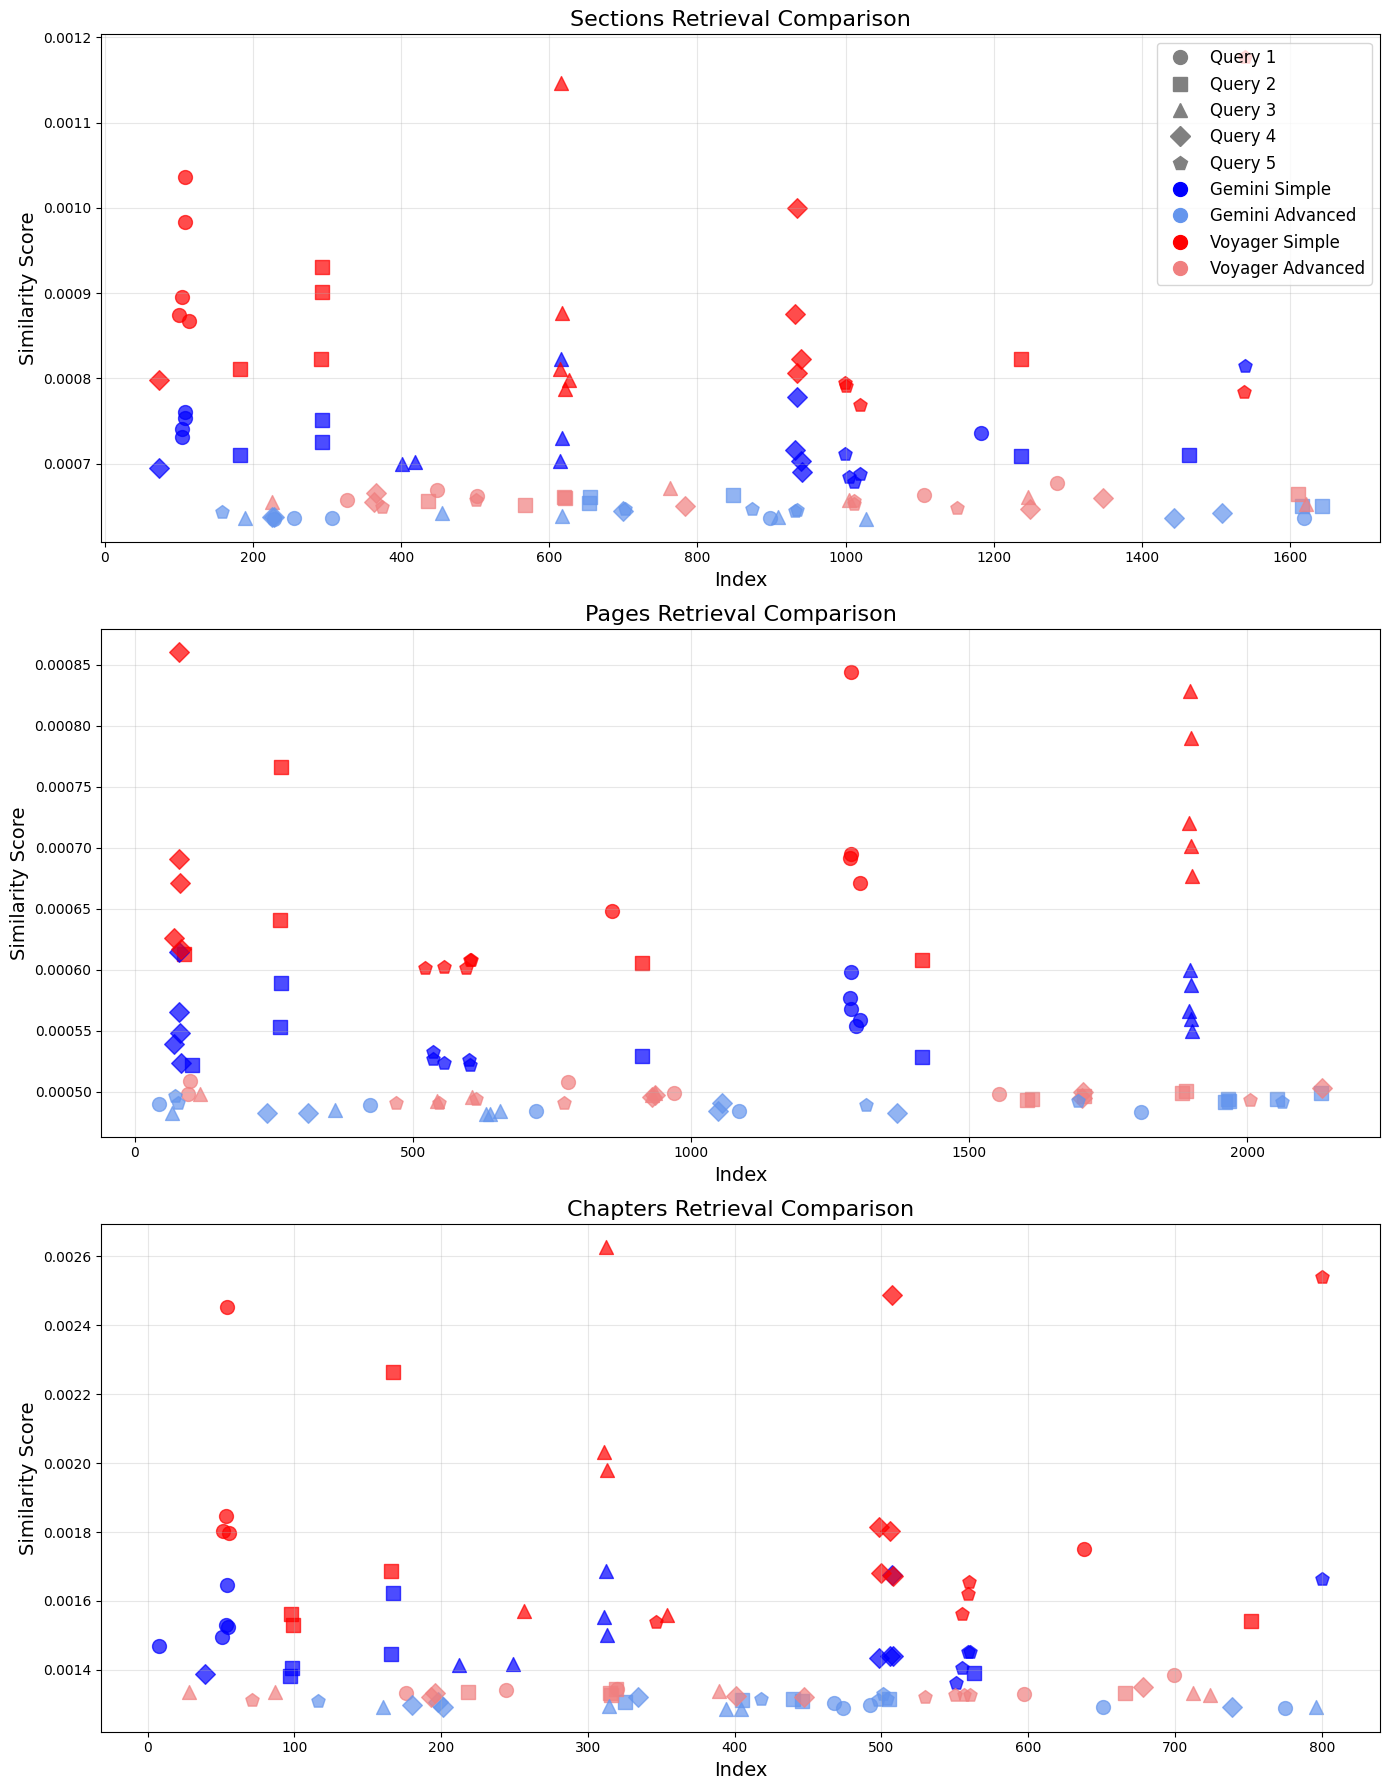

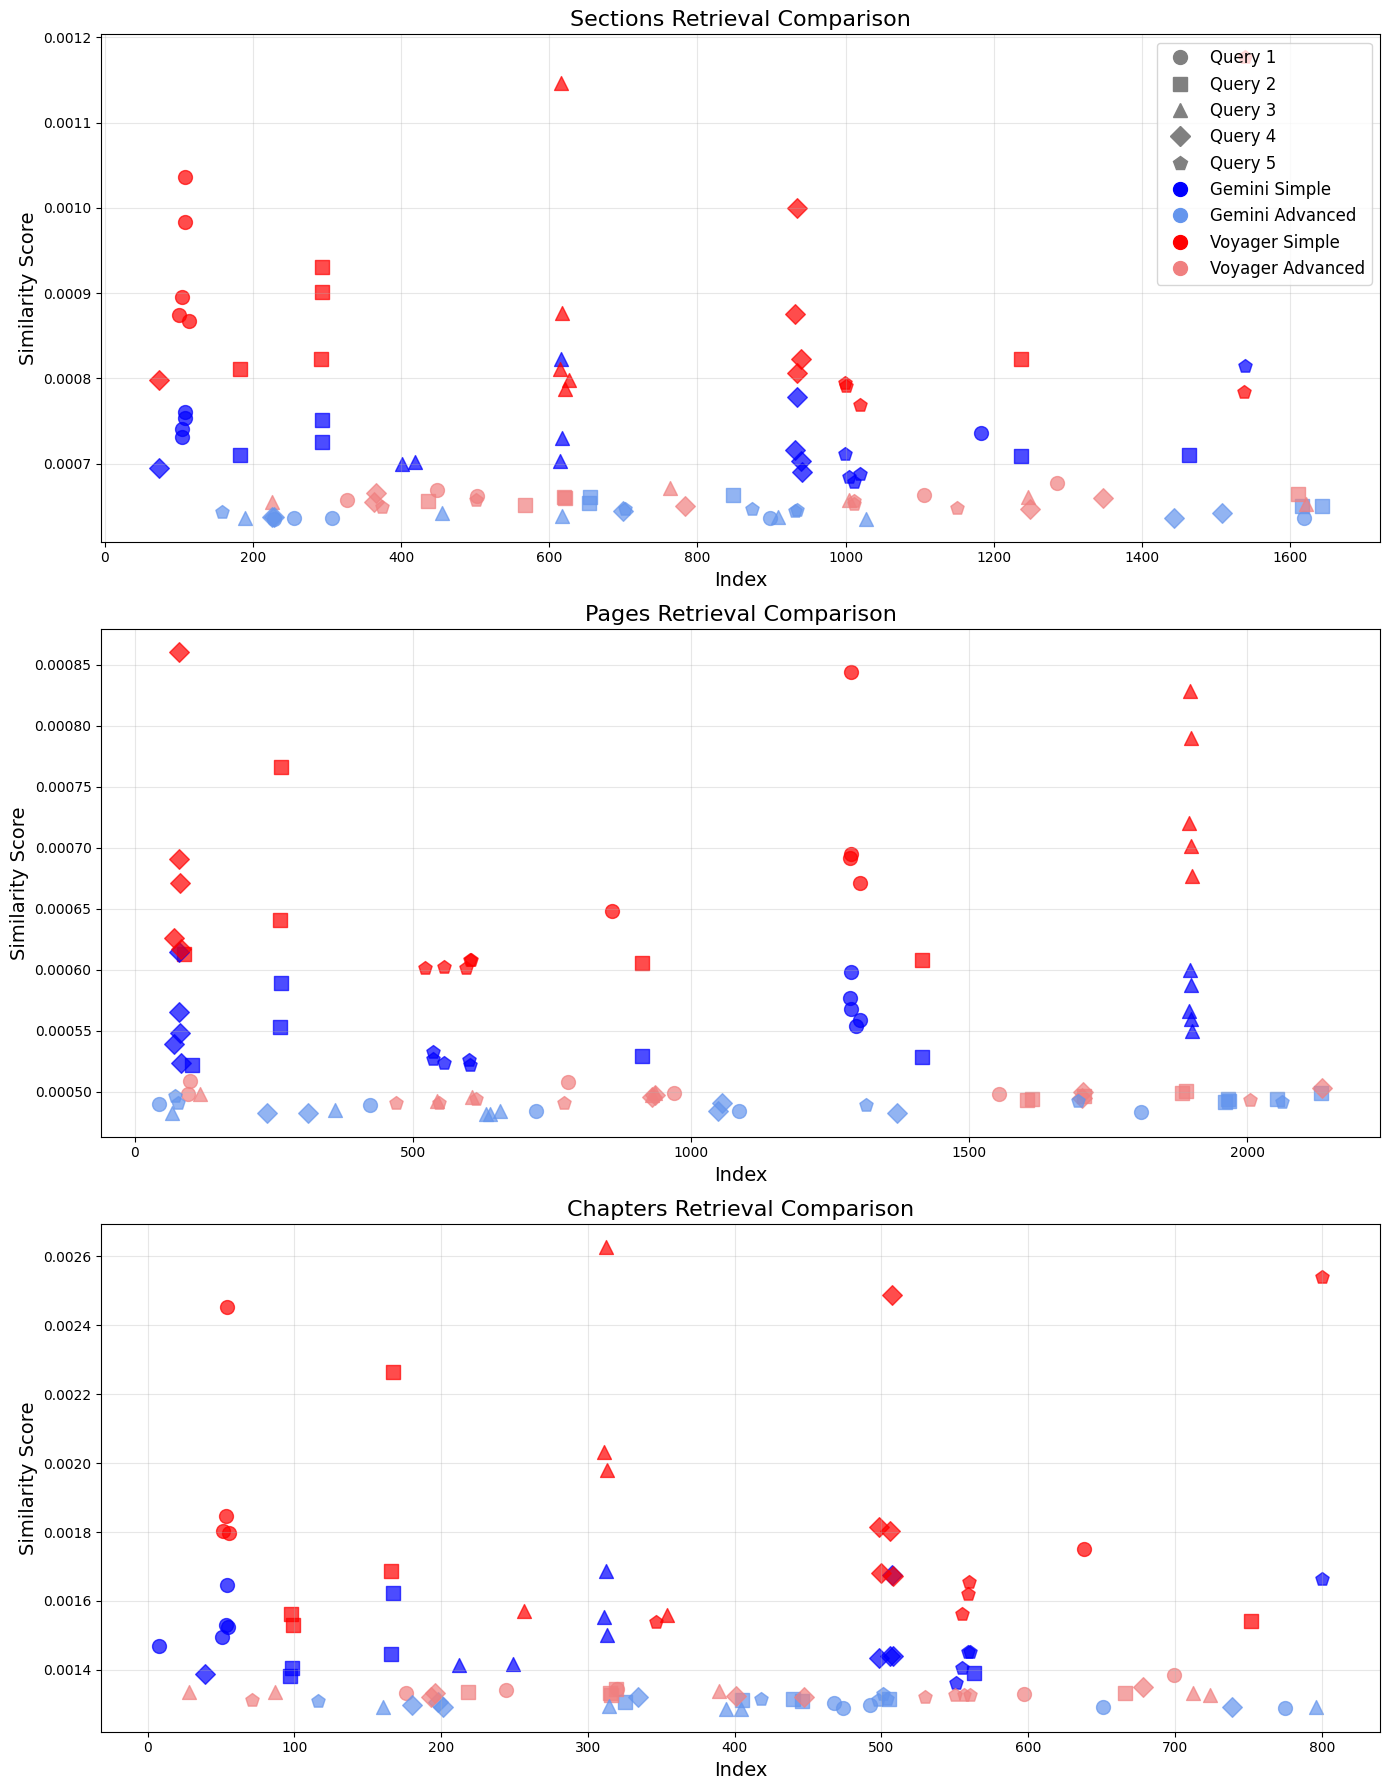

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from matplotlib.lines import Line2D
from collections import defaultdict

def visualize_rag_comparison(base_path, queries):
    """
    Create scatter plots comparing Gemini and Voyager results across different granularities
    for both forward functions.
    
    Args:
        base_path: Path to embeddings
        queries: List of query strings to test
    """
    # Setup figure
    fig, axes = plt.subplots(3, 1, figsize=(14, 18))
    
    # Define marker styles
    markers = ['o', 's', '^', 'D', 'p']
    
    # Colors for different models and functions
    colors = {
        ('gemini', 'simple'): 'blue',
        ('gemini', 'advanced'): 'cornflowerblue',
        ('voyager', 'simple'): 'red',
        ('voyager', 'advanced'): 'lightcoral'
    }
    
    # Granularities to plot
    granularities = ['sections', 'pages', 'chapters']
    
    # Store all results
    all_results = defaultdict(list)
    
    # Process each query
    for q_idx, query in enumerate(queries):
        # Run both forward functions
        for forward_fn in ["simple", "advanced"]:
            # Create model and test
            loader = LegalEmbeddingLoader(base_path)
            gemini_embeddings, voyager_embeddings, metadata = loader.load_embeddings()
            
            model = FusionRetrival(output_dim=1024)
            query_analyzer = LegalQueryAnalyzer()
            query_output = query_analyzer.analyze_query(str(query))
            
            if forward_fn == "simple":
                output = model.forward(
                    gemini_embeddings, 
                    voyager_embeddings, 
                    torch.tensor(query_output['gemini_embedding']),
                    torch.tensor(query_output['voyage_embedding'])
                )
            else:
                output = model.forward1(
                    gemini_embeddings, 
                    voyager_embeddings, 
                    torch.tensor(query_output['gemini_embedding']),
                    torch.tensor(query_output['voyage_embedding'])
                )
            
            # Extract and store results
            for granularity_idx, granularity in enumerate(granularities):
                if granularity in output['top_indices']:
                    # Get indices and values
                    gemini_indices = [int(idx.item()) if hasattr(idx, 'item') else int(idx) 
                                     for idx in output['top_indices'][granularity]["gemini_top_indices"]]
                    gemini_values = [float(val.item()) if hasattr(val, 'item') else float(val) 
                                    for val in output['top_indices'][granularity]["gemini_top_values"]]
                    
                    voyager_indices = [int(idx.item()) if hasattr(idx, 'item') else int(idx) 
                                      for idx in output['top_indices'][granularity]["voyager_top_indices"]]
                    voyager_values = [float(val.item()) if hasattr(val, 'item') else float(val) 
                                     for val in output['top_indices'][granularity]["voyager_top_values"]]
                    
                    # Store for plotting
                    for idx, val in zip(gemini_indices, gemini_values):
                        all_results[(granularity, 'gemini', forward_fn, q_idx)].append((idx, val))
                    
                    for idx, val in zip(voyager_indices, voyager_values):
                        all_results[(granularity, 'voyager', forward_fn, q_idx)].append((idx, val))
    
    # Plot results for each granularity
    for granularity_idx, granularity in enumerate(granularities):
        ax = axes[granularity_idx]
        
        # Plot points for each query, model, and forward function
        for q_idx in range(len(queries)):
            for model in ['gemini', 'voyager']:
                for forward_fn, fn_label in [("simple", "Simple"), ("advanced", "Advanced")]:
                    # Get data
                    data = all_results.get((granularity, model, forward_fn, q_idx), [])
                    
                    if data:
                        x_vals, y_vals = zip(*data)
                        
                        # Add some jitter to avoid overlapping points
                        x_vals = [x + (random.random() - 0.5) * 0.3 for x in x_vals]
                        
                        # Plot
                        ax.scatter(
                            x_vals, 
                            y_vals, 
                            c=colors[(model, forward_fn)],
                            marker=markers[q_idx],
                            alpha=0.7,
                            s=100,
                            label=f"Query {q_idx+1}: {model.capitalize()} {fn_label}"
                        )
        
        # Set titles and labels
        ax.set_title(f"{granularity.capitalize()} Retrieval Comparison", fontsize=16)
        ax.set_xlabel("Index", fontsize=14)
        ax.set_ylabel("Similarity Score", fontsize=14)
        ax.grid(True, alpha=0.3)
        
        # Only add legend to first plot to avoid repetition
        if granularity_idx == 0:
            # Create custom legend entries
            legend_elements = []
            
            # Add query markers with proper shape
            for q_idx in range(len(queries)):
                legend_elements.append(
                    Line2D([0], [0], marker=markers[q_idx], color='gray', 
                           linestyle='None', markersize=10, label=f"Query {q_idx+1}")
                )
            
            # Add model and function combinations
            for model in ['gemini', 'voyager']:
                for forward_fn, fn_label in [("simple", "Simple"), ("advanced", "Advanced")]:
                    legend_elements.append(
                        Line2D([0], [0], marker='o', color=colors[(model, forward_fn)],
                               linestyle='None', markersize=10, 
                               label=f"{model.capitalize()} {fn_label}")
                    )
            
            ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.tight_layout()
    return fig

# Generate sample queries
sample_queries = [
    get_processed_content_by_index(54, source="chapters", model= "gemini"),
    get_processed_content_by_index(167, source="chapters", model= "gemini"),
    get_processed_content_by_index(312, source="chapters", model= "gemini"),
    get_processed_content_by_index(507, source="chapters", model= "gemini"),
    get_processed_content_by_index(800, source="chapters", model= "gemini")
]

# Create visualization
visualize_rag_comparison("New_Embeddings_2025", sample_queries)
plt.savefig('rag_comparison_visualization.png', dpi=300, bbox_inches='tight')
plt.close()

# Function to demonstrate running the visualization
def run_visualization_demo():
    """
    Demo function to run the visualization with the sample queries.
    """
    print("Generating RAG comparison visualization...")
    fig = visualize_rag_comparison("New_Embeddings_2025", sample_queries)
    
    print("Visualization complete. Here's how to interpret the plots:")
    print("- Each plot shows a different granularity: sections, pages, and chapters")
    print("- Points are colored by model (Gemini: blue, Voyager: red)")
    print("- Darker colors represent the Simple approach")
    print("- Lighter colors represent the Advanced approach")
    print("- Different markers (○, □, △, ◇, ⬟) represent different queries")
    print("- The x-axis shows the index retrieved")
    print("- The y-axis shows the similarity score")
    
    print("\nThis visualization allows you to compare:")
    print("1. How the same model performs with different approaches (Simple vs Advanced)")
    print("2. How different models perform with the same approach")
    print("3. Which indices tend to be retrieved across multiple queries")
    print("4. The distribution of similarity scores across different granularities")
    
    return fig

# Run the demo
run_visualization_demo()

## Scratch Testing

In [ ]:
# def check_text_in_indices(indices, source, model, input_text):
#     """
#     Check if the input_text is present in any of the retrieved texts from given indices.
#     """
#     results = {}
#     for index in indices:
#         content = get_processed_content_by_index(index, source, model)
#         if content:
#             results[index] = str(input_text).lower() in str(content).lower()
#         else:
#             results[index] = None  # Indicates that no content was found for the index
#     return results


# def check_text_in_indices_automated(top_indices_dict, input_text, model):
#     """
#     Automated function to check if the input_text is present in any of the retrieved texts
#     from given indices specified in the top_indices_dict for the specified model.
#     """
#     results = {}
    
#     for source, indices_dict in top_indices_dict.items():
#         for key, indices in indices_dict.items():
#             # Check for the right model and source combination
#             if model == "gemini" and "gemini" in key:
#                 matches = check_text_in_indices(indices, source, "gemini", input_text)
#                 results[f"{model}_{source}_{key}"] = matches
#             elif model == "voyage" and "voyager" in key:
#                 matches = check_text_in_indices(indices, source, "voyage", input_text)
#                 results[f"{model}_{source}_{key}"] = matches

#     return results

# input_text="""Whoever, being an officer, employee or agent of the United States or of any department or agency thereof, having received public money which he is not authorized to retain as salary, pay, or emolument, fails to render his accounts for the same as provided by law is guilty of embezzlement, and shall be fined under this title or in a sum equal to the amount of the money embezzled, whichever is greater, or imprisoned not more than ten years, or both; but if the amount embezzled does not exceed $1,000, he shall be fined under this title or imprisoned not more than one year, or both.
# """

# # Call the automated function for "gemini" model
# automated_matches = check_text_in_indices_automated(output['top_indices'], input_text, "gemini")
# print(automated_matches)

# # Call the automated function for "voyage" model
# automated_matches_voyage = check_text_in_indices_automated(output['top_indices'], input_text, "voyage")
# print(automated_matches_voyage)

{'gemini_sections_gemini_top_values': {tensor(0.0007, grad_fn=<UnbindBackward0>): None, tensor(0.0006, grad_fn=<UnbindBackward0>): None, tensor(0.0006, grad_fn=<UnbindBackward0>): None, tensor(0.0006, grad_fn=<UnbindBackward0>): None, tensor(0.0006, grad_fn=<UnbindBackward0>): None}, 'gemini_sections_gemini_top_indices': {tensor(228): None, tensor(786): None, tensor(223): None, tensor(1150): None, tensor(684): None}, 'gemini_chapters_gemini_top_values': {tensor(0.0013, grad_fn=<UnbindBackward0>): None, tensor(0.0013, grad_fn=<UnbindBackward0>): None, tensor(0.0013, grad_fn=<UnbindBackward0>): None, tensor(0.0013, grad_fn=<UnbindBackward0>): None, tensor(0.0013, grad_fn=<UnbindBackward0>): None}, 'gemini_chapters_gemini_top_indices': {tensor(246): None, tensor(502): None, tensor(405): None, tensor(242): None, tensor(565): None}, 'gemini_pages_gemini_top_values': {tensor(0.0005, grad_fn=<UnbindBackward0>): None, tensor(0.0005, grad_fn=<UnbindBackward0>): None, tensor(0.0005, grad_fn=<Unb